In [1]:
#where to load the net to use
NN_PATH = 'trained/bright_res/bright_res_best.pth'
LABELS_PATH = 'data/images_scraped/'

using_res = True
ssz=200

In [2]:
import torch, torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize, Compose
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip, crop
import matplotlib.pyplot as plt

import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image
from PIL.features import pilinfo

from copy import deepcopy


import traceback
import warnings
warnings.filterwarnings("error")

import cv2
from numpy import asarray
import copy
import argparse

import os
import matplotlib.patches as patches

### Defining the neural network

In [3]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [5]:
if not using_res:
    class Net(nn.Module):

        def __init__(self):
            super(Net, self).__init__()

            #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
            self.conv1 = nn.Conv2d(1, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)        
            self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
            self.fc_layer2 = nn.Linear(120, 84)
            self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

        def forward(self, x):
            # Max pooling over a (2, 2) window
            x = self.pool(F.relu(self.conv1(x)))
            #print ('conv1', x.shape)
            # If the size is a square, you can specify with a single number
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
            #print ('flatten', x.shape)
            x = F.relu(self.fc_layer1(x))
            x = F.relu(self.fc_layer2(x))
            x = self.fc_layer3(x)
            return x

### Testing the network on test set

In [6]:
if not using_res:
    loaded = Net()
else:
    loaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


In [7]:
loaded.load_state_dict(torch.load(NN_PATH))
loaded.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
only_dirs = [ name for name in os.listdir(LABELS_PATH) if 
                 os.path.isdir(os.path.join(LABELS_PATH, name)) ]

diz = {} #diz [key=LABEL_INDEX, value=LABEL_NAME]
diz2 = {} #diz2 [key=LABEL_INDEX, value=PROB_PREDICTION]
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    diz2[nocl] = 0
    nocl+=1
    
print(diz.values())

dict_values(['hyundai', 'lexus', 'mazda', 'mercedes', 'opel', 'skoda', 'toyota', 'volkswagen'])


In [9]:
def preprocess(im, x0, y0):
    cropped = crop(im, y0, x0, ssz, ssz)
    actions = Compose([
                Resize(300),
                CenterCrop(300),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
    return actions(cropped)

In [115]:
def analyze_and_drawbar(frame):
    #producing predictions and sort to get probabilities
    target_frame = frame[None, :] #adding 1 dim to simulate batch
    out = loaded(target_frame)
    _, best_pred = torch.max(out.data, 1)
    perc = torch.nn.functional.softmax(out, dim=1)[0] * 100    
    _, indices = torch.sort(out, descending=True)
    
    # fig, ax = plt.subplots(figsize=(16,6),nrows=1, ncols=1)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    #creating barplot
    plt.xlim(0, 100)
    for idx in indices[0][:8]:
        diz2[idx.item()] = perc[idx].item()

    keys = list(diz.keys())
    plt.barh(keys, diz2.values())
    ax.xaxis.set_ticks(np.linspace(0,100,11))
    ax.set_yticks(keys, labels=list(diz.values()))
    ax.grid(axis='x')
    ax.tick_params(axis='both', labelsize=15)
    ax.set_xlabel('confidence', fontsize=17, fontweight='bold')
    ax.set_ylabel('labels', fontsize=17, fontweight='bold')
    ax.set_title('predictions', fontsize=20, fontweight='bold')

    buf = io.BytesIO()
    fig.savefig(buf, format='jpeg', bbox_inches="tight", dpi=120)
    buf.seek(0)
    frame = Image.open(buf)
    plt.close()
    
    return frame

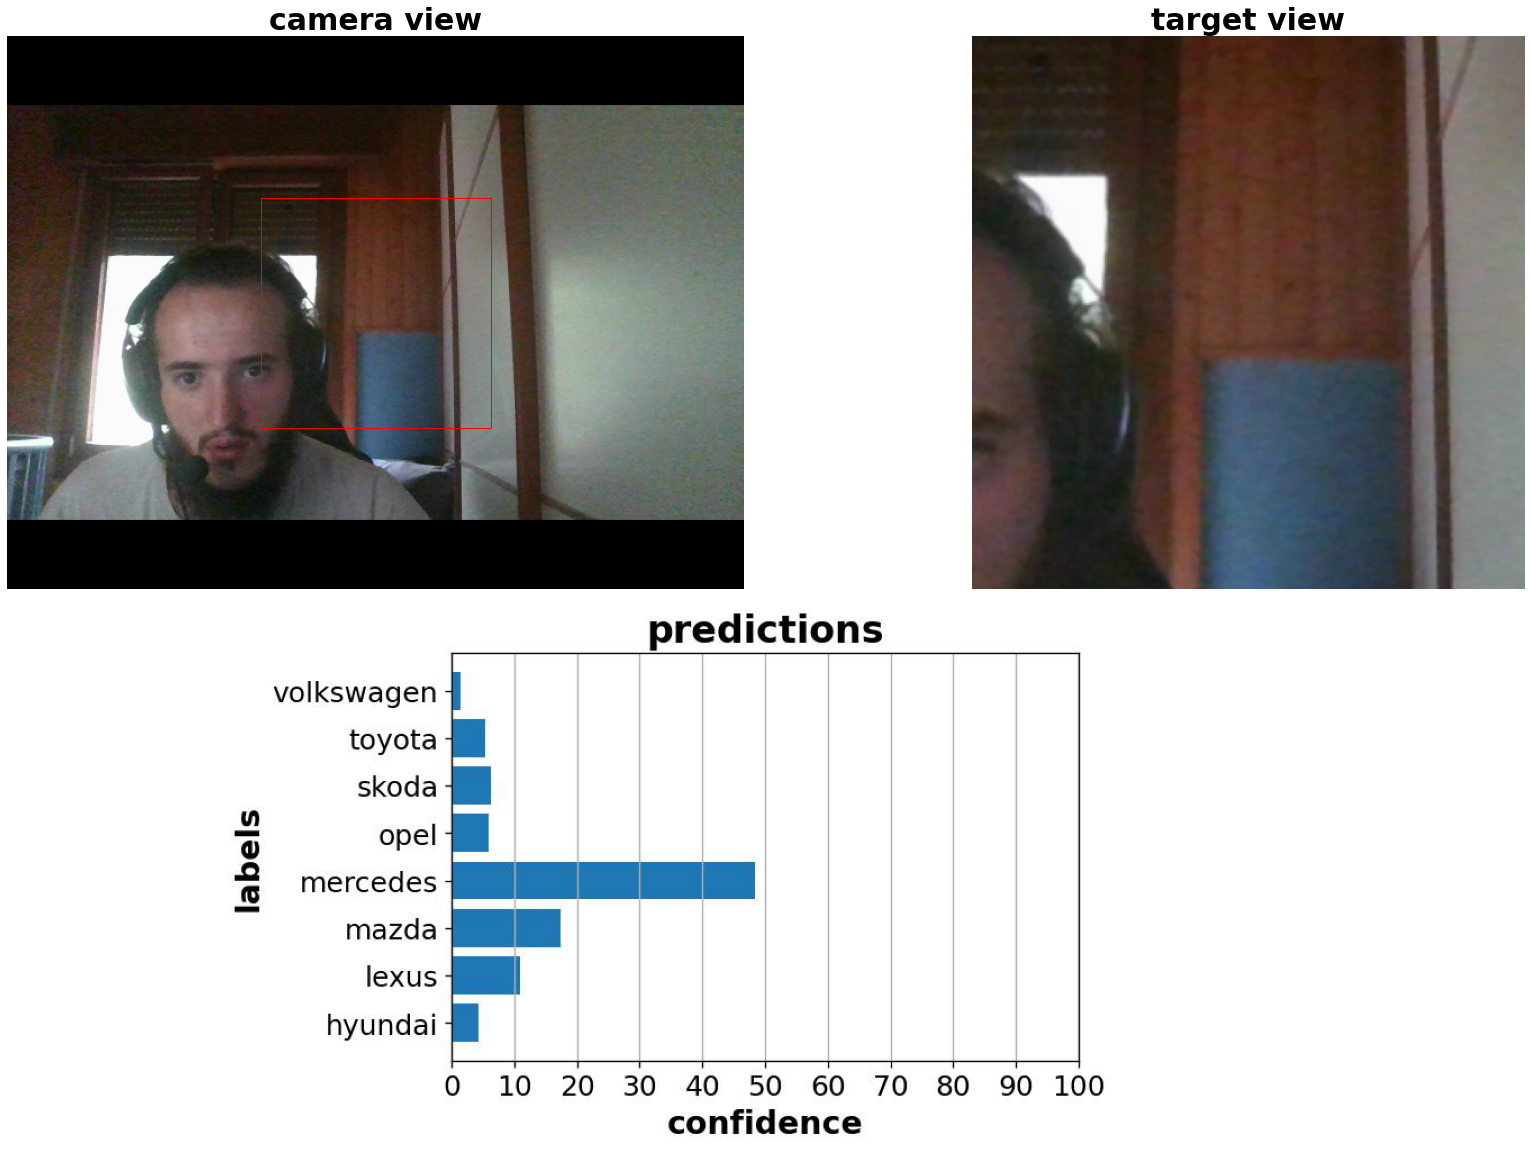

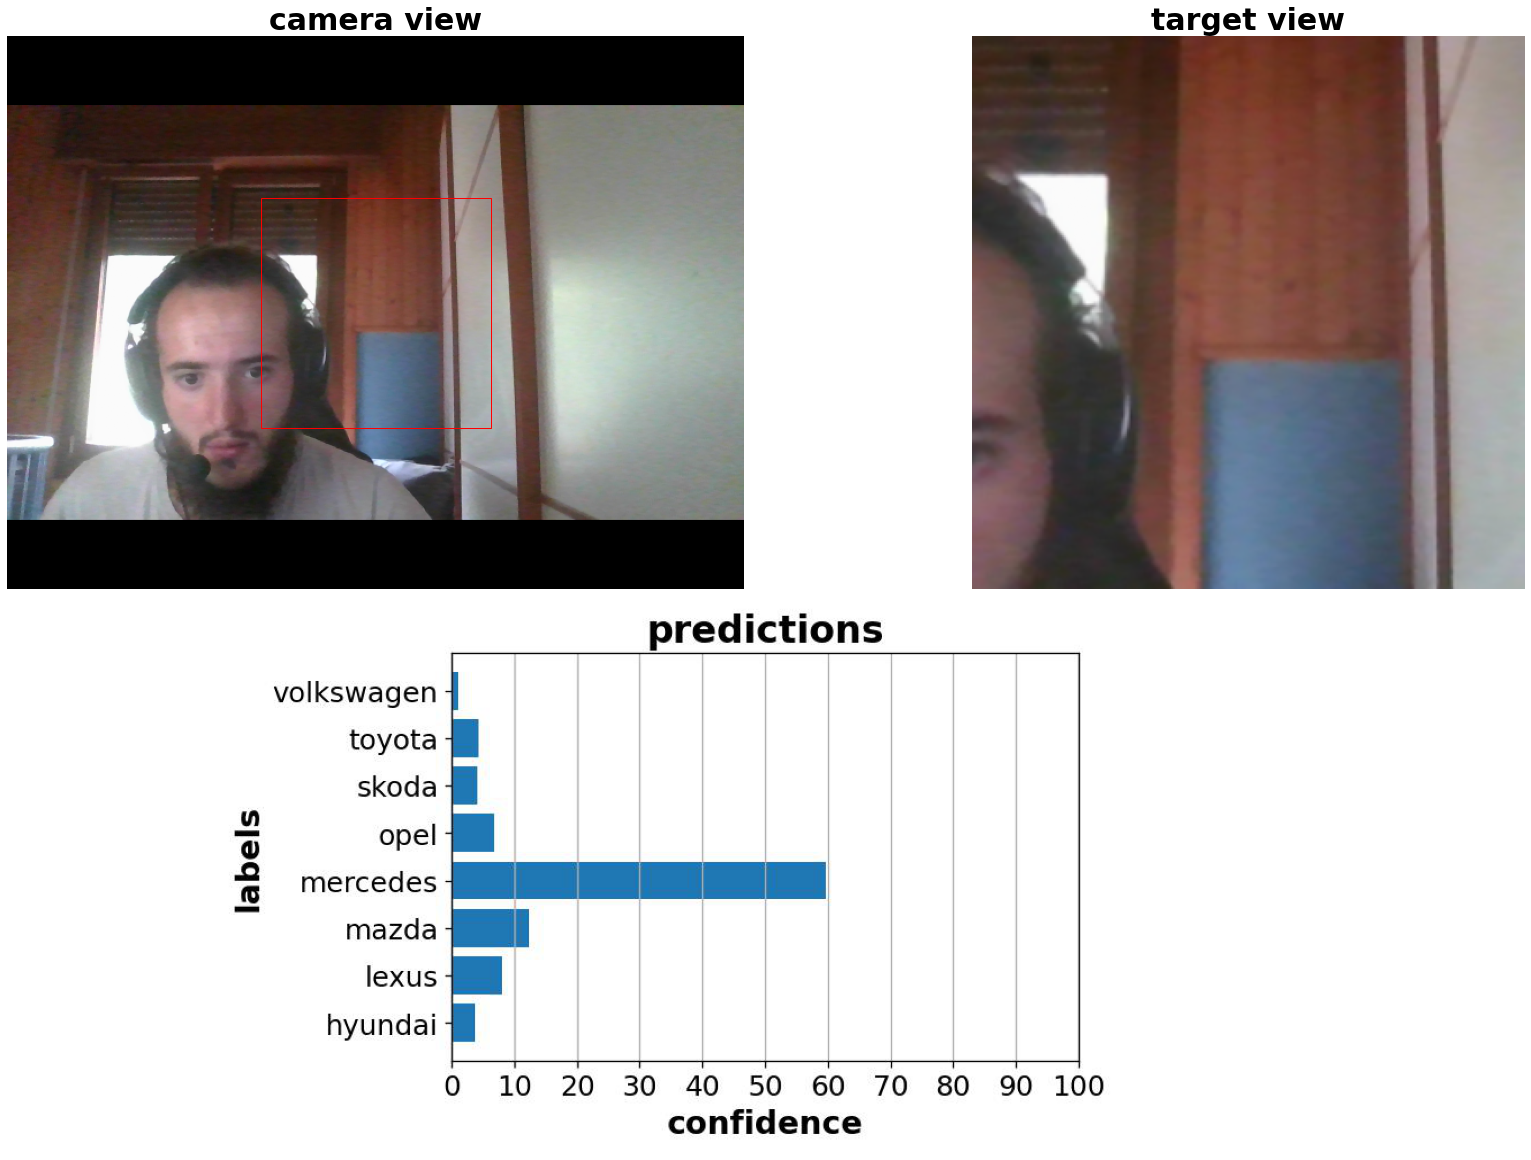

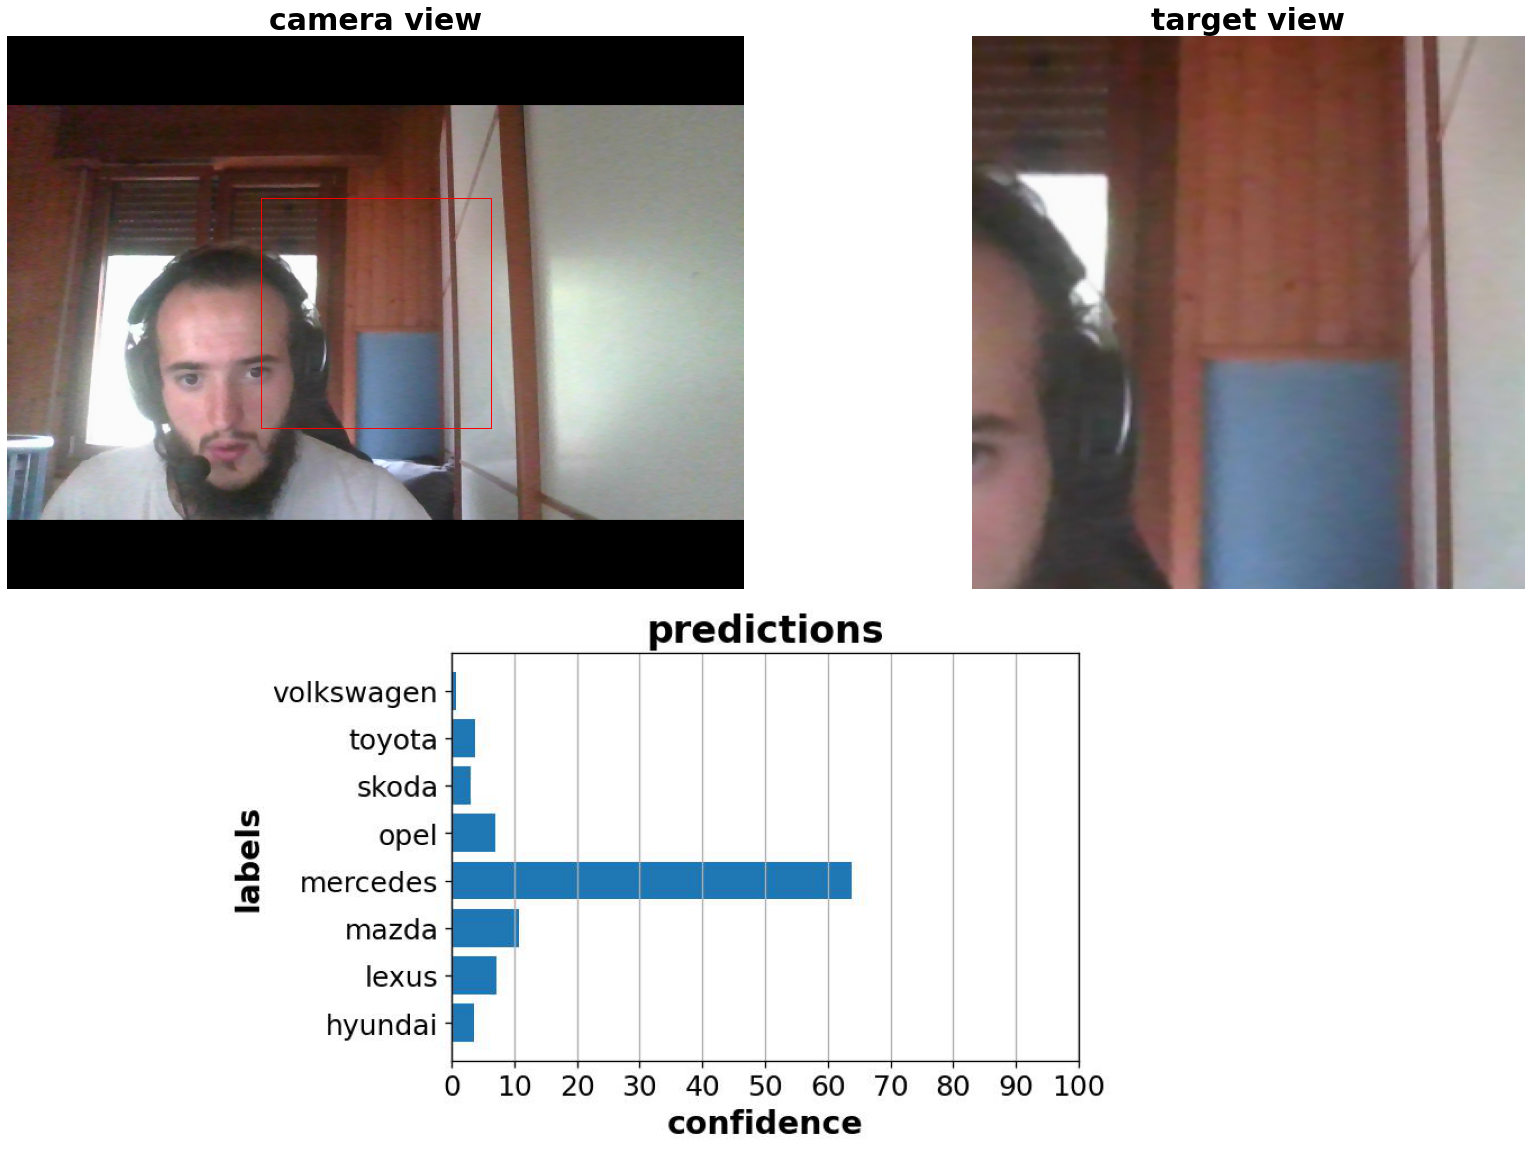

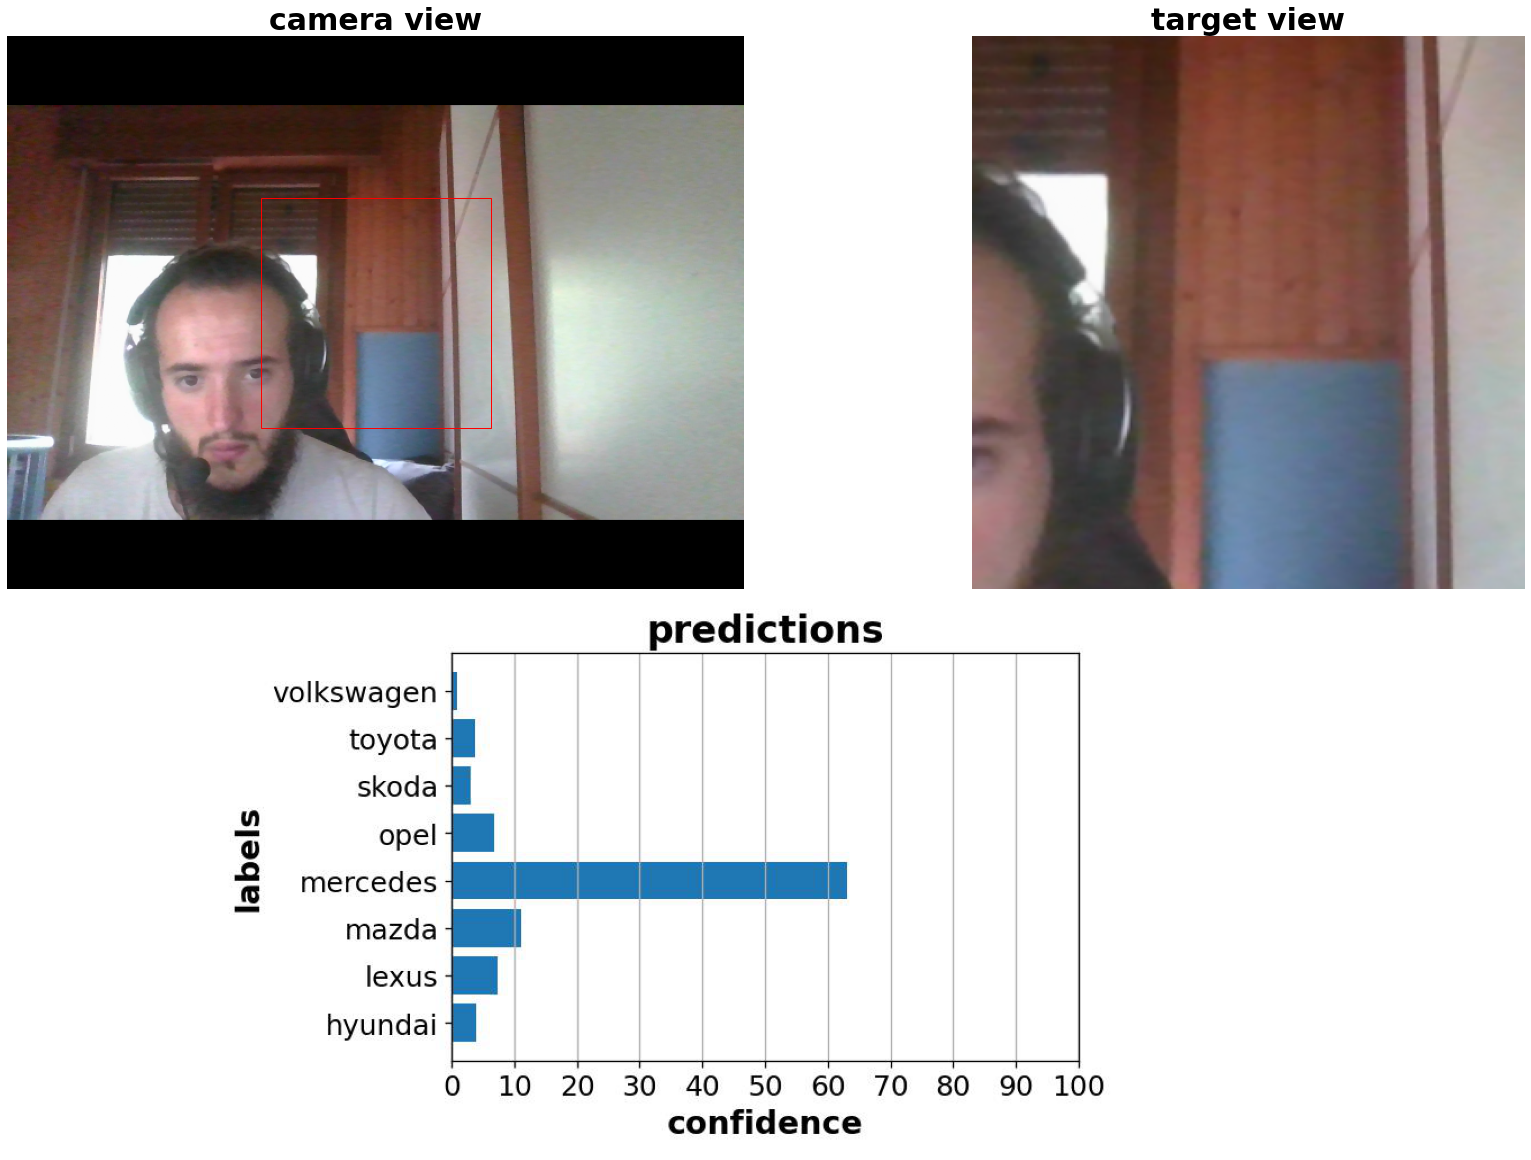

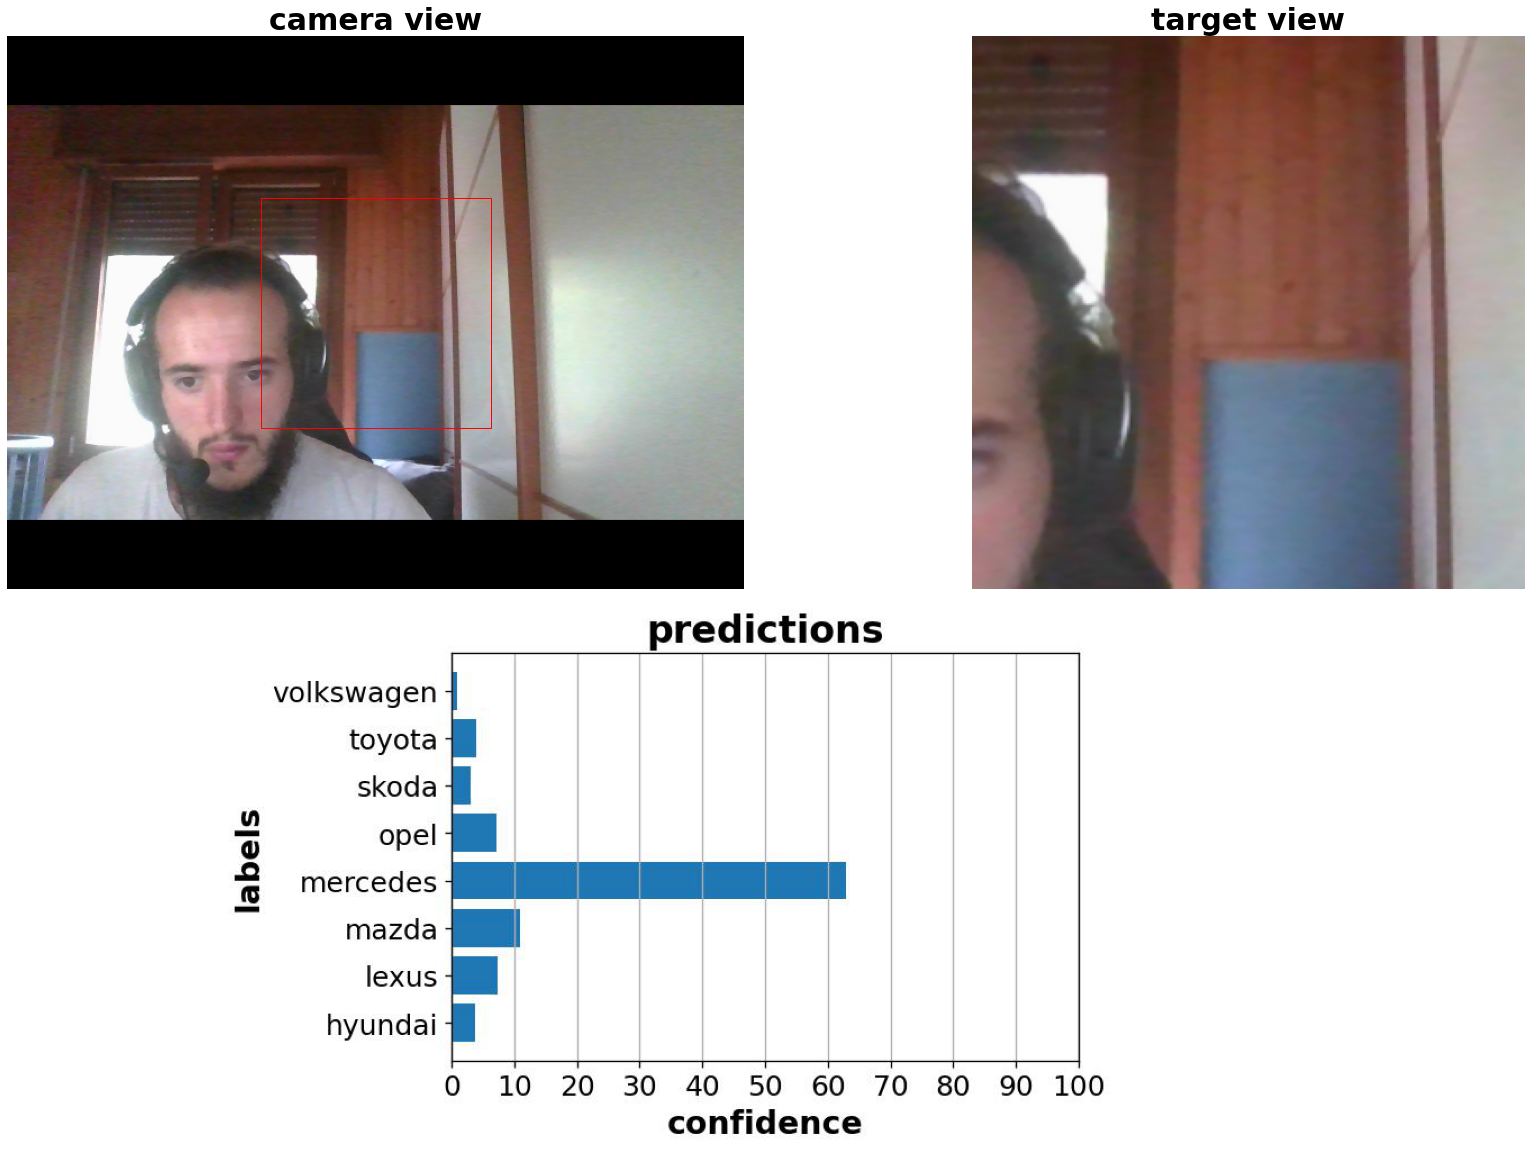

In [116]:
parser = argparse.ArgumentParser(description='Car logo realtime demo.')
parser.add_argument('--fullscreen', action='store_true', help='run in fullscreen')
# args = parser.parse_args() #removed since conflicts with jupyter console
args, unknown = parser.parse_known_args()

# Setup acquisition
cap = cv2.VideoCapture(0)
cap.release()

windowname="Car logo Live Demo"
cv2.namedWindow(windowname, cv2.WND_PROP_FULLSCREEN)
cv2.moveWindow(windowname, 0, 0)
cv2.setWindowProperty(windowname, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

cap = cv2.VideoCapture(0)
for i in range(5):
# while(True):
    ret, img = cap.read()
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im = cv2.flip(im, 1)
    
    h, w = im.shape[0:2]
    x0 = w // 2 - ssz // 2
    y0 = h // 2 - ssz // 2
    
    
    im_tensor = to_tensor(np.array(im))
    rect = patches.Rectangle((x0, y0), ssz, ssz, linewidth=1,
                         edgecolor='r', facecolor="none")
    
    fig = plt.figure(figsize=(24, 16), constrained_layout=True)
    # fig = plt.figure()

    # spec = fig.add_gridspec(2, 3, hspace=0.1, wspace=0.1, width_ratios=(2,2,1))
    spec = fig.add_gridspec(nrows=2, ncols=3, left=0.1, right=0.6)
    
    ax_camera = fig.add_subplot(spec[0, :-1])
    ax_target = fig.add_subplot(spec[0, 2])
    ax_barh = fig.add_subplot(spec[1, :])
    # fig.set_dpi(200)
    plt.axis("off")
    
    ax_camera.imshow(im_tensor.permute(1,2,0))
    ax_camera.add_patch(rect)
    ax_camera.set_title('camera view', fontsize=30, fontweight='bold')
    ax_camera.axis('off')
    # plt.show()
    
    frame = preprocess(im_tensor, x0, y0)
    frame_plt = frame * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    ax_target.imshow(frame_plt.permute(1,2,0))
    ax_target.set_title('target view', fontsize=30, fontweight='bold')
    ax_target.axis('off')
    
    
    img_barplt = analyze_and_drawbar(frame)
    ax_barh.imshow(img_barplt)
    
    
    buf = io.BytesIO()
    fig.savefig(buf, format='jpeg', bbox_inches='tight')
    buf.seek(0)
    full_screen_img = Image.open(buf)
    # plt.close()
    
    full_screen_img = (to_tensor(full_screen_img)).permute(1,2,0).numpy()
    full_screen_img = (full_screen_img*255).astype(np.uint8)
    
    # print(full_screen_img.shape)
    
    cv2.imshow(windowname,cv2.cvtColor(full_screen_img, cv2.COLOR_RGB2BGR))
    
    key = cv2.waitKey(20)
#     if key & 0xFF == ord('1'):
#         remap_std=0.1
#     if key & 0xFF == ord('2'):
#         remap_std=0.2
    # if key & 0xFF == ord('3'):
#         remap_std=0.3
#     if key & 0xFF == ord('4'):
#         remap_std=0.4
#     if key & 0xFF == ord('5'):
#         remap_std=0.5
#     if key & 0xFF == ord('c'):
#         mappings,densemapping=mkmappings_color()
#         mkviz=True
#     if key & 0xFF == ord('g'):
#         mappings,densemapping=mkmappings_gray()
#         mkviz=True
#     if key & 0xFF == ord('v'):
#         mkviz=not mkviz
    if key & 0xFF == ord('q'):
        break
    

cap.release()
cv2.startWindowThread()
cv2.destroyAllWindows()